In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import os
import cv2
import pickle
import csv

from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2grey
from skimage import data, exposure
from skimage.data import camera

# Library for scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Library for LIBSVM
from libsvm.svmutil import *
from itertools import combinations

# Library fror tensorflow and keras
import tensorflow as tf
import tensorflow.keras
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import imagenet_utils
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import h5py

/home/insignite/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/insignite/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/insignite/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/insignite/miniconda3/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
# 101 is main dataset, 102 is for testing with smaller dataset
data_dir = "/mnt/c/Users/nhmin/Downloads/food-101"
bin_n = 16 # Number of bin
project_dir = os.getcwd()
model_dir = "/mnt/c/Users/nhmin/Downloads"
class_label = {"pad_thai" : 0, "pho" : 1, "ramen" : 2, "spaghetti_bolognese" : 3, "spaghetti_carbonara" : 4}

In [3]:
def load_json(path):
    final_data = dict()
    # Load in json file to create dictionary: key = class label; value = file path
    with open(path, 'r') as file:
        data = json.load(file)
    # Only get information from needed class
    for label in class_label:
        final_data.update({label : data.get(label)})
    return final_data

#=========================
# Exclusive block for showing a sample of how json load data
# data_head = 5
# sample_data = load_json(parent_dir + "/meta/test.json")
# for key, value in sample_data:
#     print(key)
#     print(value[i] for i in range(0,data_head))
#     for i in range(0, data_head):
#         print(value[i])   
#=========================

In [4]:
def get_key(val):
    for key, value in class_label.items():
        if(val == value): return key
    return None


In [5]:
def create_data(json_data):
    # Create train data
    file_names_list = []
    label_list = []
    for label in json_data.keys():
        #file_names = os.listdir(data_dir + '/images/' + label)
        file_names = json_data.get(label)
        for file in file_names:
            file = file.split('/')[1] + '.jpg'
            file_names_list.append(file)
            label_list.append(class_label.get(label))
    # Create dataframe
    data_df = pd.DataFrame({
        'filename' : file_names_list,
        'label' : label_list
    })
#     # Splitting training and validating data
#     train_df, validate_df = train_test_split(data_df, test_size=0.20, random_state=42)
#     # When splitting, train_df and validate_df contain original index. this is to reset the index
#     train_df = train_df.reset_index(drop=True)
#     validate_df = validate_df.reset_index(drop=True)
    

    return data_df

In [6]:
def create_feature(data_df, pre_model):
    x_tmp = []
    size = len(data_df['filename'])
    print("total image: ", size)
    for i in range(0,size):
        image = data_df['filename'][i]
        label = data_df['label'][i]
        path = data_dir + '/images/' + get_key(label) + '/' + image
        #image_np = get_image(path)
        image_np = load_img(path, target_size=(227,227))
        image_np = img_to_array(image_np)
        image_np = np.expand_dims(image_np,axis=0)
        image_np = imagenet_utils.preprocess_input(image_np)
        x_tmp.append(image_np)
    x = np.vstack(x_tmp)
    features = pre_model.predict(x, batch_size=32)
    last_layer = pre_model.layers[-1].output_shape
    print("Reshape:", features.shape[0], last_layer[1] * last_layer[2] * last_layer[3])
    features_flatten = features.reshape((features.shape[0], last_layer[1] * last_layer[2] * last_layer[3]))
    return features_flatten

In [7]:
def grid_search(train_df, train_feature):
    # Grid Search
    kernel = [0,1,2]
    cost = [2**(-5),2**(-3),2**(-1),1,2,2**3,2**5,2**7,2**9,2**11,2**13,2**15]
    gamma = [2**(-15),2**(-13),2**(-11),2**(-9),2**(-7),2**(-5),2**(-3),2**(-1),1,2,2**3]
    # Create all the combination O(n^3)
    combine_list = [(k,g,c) for k in kernel for g in gamma for c in cost]
    accuracy_record = {}
    highest_acc = -1.0
    highest_params = (0,0,0)
    for i in range(0, len(combine_list)):
        train_val_acc = svm_train(train_df['label'].tolist(), train_feature, '-s 0 -t %s -v 10 -g %s -c %s -b 1' % combine_list[i])
        if(train_model > highest_acc):
            highest_acc = train_model
            highest_params = combine_list[i]
        accuracy_record[combine_list[i]] = train_model
    print('Highest Accuracy and Params: ')
    print(highest_params, ':', highest_acc)
    return accuracy_record

In [8]:
# load json file
train_json = load_json(data_dir + '/meta/train.json')
train_df = create_data(train_json)

#model = tf.keras.models.load_model(model_dir + '227-imgsz-32-bsz-0.01-lr-30-ep/saved_model.pb')
model = tf.keras.models.load_model(model_dir + '/alexNet_best_weigths.hdf5')
drop_layer = 0
for i in range(len(model.layers)-1, 0, -1):
    name = model.layers[i].name.split('_')[0]
    if(name == 'flatten'):
        drop_layer+= 1
        break
    drop_layer += 1
new_model = tf.keras.Sequential()
for layer in model.layers[:-drop_layer]:
    new_model.add(layer)
new_model.trainable = False
new_model.build((227,227,3))
new_model.summary()
train_feature = create_feature(train_df, new_model)
# Grid Search
# Use small dataset to make search much faster
# acc_record = grid_search(train_df, train_feature)
# print('Validation Record: ')
# for key in acc_record.keys():
#     print(key, ':', acc_record.get(key))

# b = 1 will give prob est
# highest params for food-101 dataset
# (0, 2, 0.5)
# train_model = svm_train(train_df['label'].tolist(), train_feature, '-s 0 -t 0 -g 2 -c 0.5 -b 1')
# svm_save_model('all_food_classification.model', train_model)
print('Training finished.')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
activation_18 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_19 (Activation)   (None, 25, 25, 256)       0         
____________________________

In [50]:
print("Train Dataframe")
print(train_df)
print("")
print("Train Feature")
print(train_feature.shape)

Train Dataframe
         filename  label
0     1004763.jpg      0
1     1009595.jpg      0
2     1011059.jpg      0
3     1011238.jpg      0
4     1013966.jpg      0
...           ...    ...
3745   977656.jpg      4
3746   980577.jpg      4
3747   981334.jpg      4
3748   991708.jpg      4
3749   992617.jpg      4

[3750 rows x 2 columns]

Train Feature
(3750, 6400)


In [45]:
def test_dataset():
    model = svm_load_model('all_food_classification.model')
    #test_json = load_json(data_dir + '/meta/test.json')
    test_json = load_json(model_dir + '/test_group/test.json')
    test_df = create_data(test_json)
    test_feature = create_feature(test_df, new_model)
    
    # Predict
    p_label, p_acc, p_val = svm_predict(test_df['label'].tolist(), test_feature, model, '-b 0')
    acc, mse, scc = evaluations(test_df['label'].tolist(), p_label)
    print("Test acc: ", acc)
    # print wront classify image
    counter = 0
    correct = 25
    incorrect = 25
    for i in range(0, len(p_label)):
        #img = load_img(model_dir+ '/test_group/' + get_key(train_df['label'][i]) + '/' + test_df['filename'][i])
#         if(p_label[i] != test_df['label'][i] and incorrect > 0):
#             print(test_df['filename'][i])
#             print('True label: ', get_key(test_df['label'][i]), " Predicted label: ", get_key(p_label[i]))
#             incorrect -=1
        if(p_label[i] != test_df['label'][i] and incorrect > 0):
            print(test_df['filename'][i])
            print('True label: ', get_key(test_df['label'][i]), " Predicted label: ", get_key(p_label[i]))
        
    return p_label
img1 = load_img(data_dir + '/images/' + get_key(train_df['label'][25]) + '/' + train_df['filename'][25])
p_label = test_dataset()

total image:  25
Reshape: 25 6400
Model supports probability estimates, but disabled in predicton.
Accuracy = 72% (18/25) (classification)
Test acc:  72.0
2735021.jpg
True label:  pad_thai  Predicted label:  spaghetti_bolognese
3089593.jpg
True label:  pad_thai  Predicted label:  ramen
2696250.jpg
True label:  pho  Predicted label:  ramen
2487409.jpg
True label:  ramen  Predicted label:  pho
2969047.jpg
True label:  spaghetti_bolognese  Predicted label:  pho
3087717.jpg
True label:  spaghetti_bolognese  Predicted label:  pad_thai
2626986.jpg
True label:  spaghetti_carbonara  Predicted label:  ramen


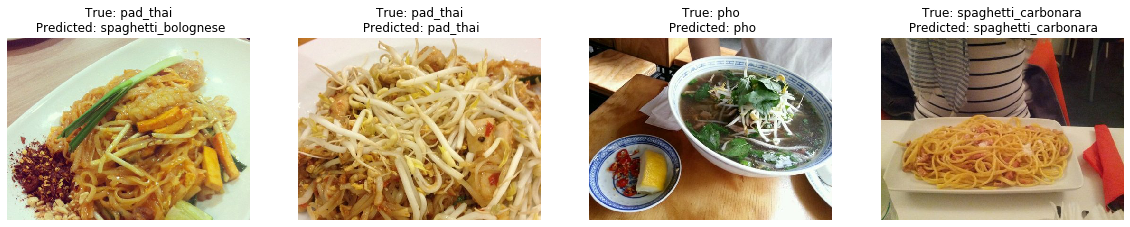

In [42]:
test_json = load_json(model_dir + '/test_group/test.json')
test_df = create_data(test_json)
img1 = load_img(model_dir+ '/test_group/' + get_key(test_df['label'][0]) + '/' + test_df['filename'][0]) #pad thai
img2 = load_img(model_dir+ '/test_group/' + get_key(test_df['label'][1]) + '/' + test_df['filename'][1]) #padthai but predict bolognese
img3 = load_img(model_dir+ '/test_group/' + get_key(test_df['label'][9]) + '/' + test_df['filename'][9]) #pho
img4 = load_img(model_dir+ '/test_group/' + get_key(test_df['label'][20]) + '/' + test_df['filename'][20]) # spaghetty_carbonara

fig1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 14), sharex=True, sharey=True)
# fig2, (ax21, ax22) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(img1, cmap=plt.cm.gray)
ax1.set_title('True: '+ get_key(test_df['label'][0]) + "\n Predicted: " + get_key(p_label[0]))
#ax1.legend('True label: '+ get_key(test_df['label'][0]) + "/n Predicted label: " + get_key(p_label[0]))

ax2.axis('off')
ax2.imshow(img2, cmap=plt.cm.gray)
ax2.set_title('True: '+ get_key(test_df['label'][1]) + "\n Predicted: " + get_key(p_label[1]))
#ax2.legend('True label: '+ get_key(test_df['label'][1]) + "/n Predicted label: " + get_key(p_label[1]))

ax3.axis('off')
ax3.imshow(img3, cmap=plt.cm.gray)
ax3.set_title('True: '+ get_key(test_df['label'][9]) + "\n Predicted: " + get_key(p_label[9]))
#ax3.legend('True label: '+ get_key(test_df['label'][9]) + "/n Predicted label: " + get_key(p_label[9]))

ax4.axis('off')
ax4.imshow(img4, cmap=plt.cm.gray)
ax4.set_title('True: '+ get_key(test_df['label'][20]) + "\n Predicted: " + get_key(p_label[20]))
#ax4.legend('True label: '+ get_key(test_df['label'][20]) + "/n Predicted label: " + get_key(p_label[20]))



plt.show()

In [24]:
# Write accuracy record to csv
def write_record_txt(path):
    kernel = []
    gamma = []
    cost = []
    acc = []
    kernel_dict = {'0' :'Linear', '1': 'Polynomial', '2' : 'RBF' }
    with open(path, 'r') as f:
        for line in f:
            values = line.split(' : ')
            params = values[0].split(',')
            kernel.append(kernel_dict.get(params[0][1:]))
            gamma.append(params[1])
            cost.append(params[2][:-1])
            acc.append(values[1][:-2])
    data_df = pd.DataFrame({
        'Kernel' : kernel,
        'Gamma' : gamma,
        'Cost' : cost,
        'Accuracy' : acc
    })
    data_df.to_csv('grid_search_record.csv')
write_record_txt(model_dir + '/grid_search_record.txt')

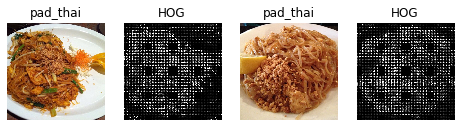

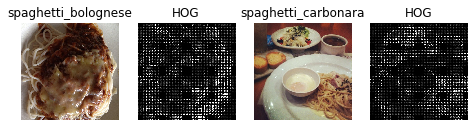

In [42]:
img1 = load_img(data_dir + '/images/' + get_key(train_df['label'][25]) + '/' + train_df['filename'][25])
img2 = load_img(data_dir + '/images/' + get_key(train_df['label'][2859]) + '/' + train_df['filename'][2859])
img3 = load_img(data_dir + '/images/' + get_key(train_df['label'][472]) + '/' + train_df['filename'][472])
img4 = load_img(data_dir + '/images/' + get_key(train_df['label'][3458]) + '/' + train_df['filename'][3458])
img1_feature, img1_image = hog(img1, orientations=8, pixels_per_cell=(8, 8), 
                               cells_per_block=(8, 8), block_norm = 'L2-Hys', visualize=True, multichannel=True)
img2_feature, img2_image = hog(img2, orientations=8, pixels_per_cell=(8, 8), 
                               cells_per_block=(8, 8), block_norm = 'L2-Hys', visualize=True, multichannel=True)
img3_feature, img3_image = hog(img3, orientations=8, pixels_per_cell=(8, 8), 
                               cells_per_block=(8, 8), block_norm = 'L2-Hys', visualize=True, multichannel=True)
img4_feature, img4_image = hog(img4, orientations=8, pixels_per_cell=(8, 8), 
                               cells_per_block=(8, 8), block_norm = 'L2-Hys', visualize=True, multichannel=True)

fig1, (ax11, ax12, ax31, ax32) = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=True)
# fig2, (ax21, ax22) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax11.axis('off')
ax11.imshow(img1, cmap=plt.cm.gray)
ax11.set_title(get_key(train_df['label'][25]))

# Rescale histogram for better display
hog_image1_rescaled = exposure.rescale_intensity(img1_image, in_range=(0, 10))
hog_image3_rescaled = exposure.rescale_intensity(img3_image, in_range=(0, 10))

ax12.axis('off')
ax12.imshow(hog_image1_rescaled, cmap=plt.cm.gray)
ax12.set_title('HOG')

ax31.axis('off')
ax31.imshow(img3, cmap=plt.cm.gray)
ax31.set_title(get_key(train_df['label'][472]))

ax32.axis('off')
ax32.imshow(hog_image3_rescaled, cmap=plt.cm.gray)
ax32.set_title('HOG')


fig2, (ax21, ax22, ax41, ax42) = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=True)
ax21.axis('off')
ax21.imshow(img2, cmap=plt.cm.gray)
ax21.set_title(get_key(train_df['label'][2859]))


hog_image2_rescaled = exposure.rescale_intensity(img2_image, in_range=(0, 10))
ax22.axis('off')
ax22.imshow(hog_image2_rescaled, cmap=plt.cm.gray)
ax22.set_title('HOG')

ax41.axis('off')
ax41.imshow(img4, cmap=plt.cm.gray)
ax41.set_title(get_key(train_df['label'][3458]))


hog_image4_rescaled = exposure.rescale_intensity(img4_image, in_range=(0, 10))
ax42.axis('off')
ax42.imshow(hog_image4_rescaled, cmap=plt.cm.gray)
ax42.set_title('HOG')


plt.show()

3.3
8.9


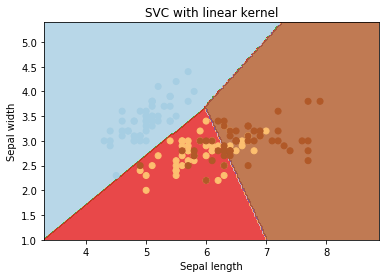

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2] # we only take the first two features. We could
 # avoid this ugly slicing by using a two-dim dataset
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0 # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=0.5,gamma=2).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
print(x_min)
print(x_max)
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = (x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

plt.subplot(1, 1, 1)
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
print('Rerun')
data_dir_1 = "/mnt/c/Users/nhmin/Downloads/food-102"
# load json file
train_json_1 = load_json(data_dir_1 + '/meta/train.json')
train_df_1 = create_data(train_json_1)
print(len(train_df_1['filename']))
train_feature_1 = create_feature(train_df_1, new_model)
# import some data to play with
# iris = datasets.load_iris()
#X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
X = train_feature_1[:,:2]
y = train_df_1['label'].tolist()

  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 0.5  # SVM regularization parameter
#lin_svc = svm.LinearSVC(C=C).fit(X, y)

Rerun
151
total image:  151
Reshape: 151 6400


In [10]:
svc = svm.SVC(kernel='linear', C=C, gamma=10).fit(X, y)

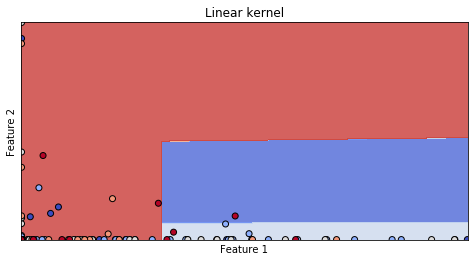

In [11]:
abc = 0
h = 1
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['Linear kernel',
          'Polynomial kernel',
          'RBF kernel']


for i, clf in enumerate((svc,abc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.figure(figsize=(8,4))
    plt.subplot(1, 1, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='black')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    break

plt.show()